In [1]:
%%capture
import numpy as np
import cv2
import pickle
import sys
from IPython.display import Audio 
from IPython.core.display import display
import re,string
from unicodedata import normalize
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os.path as path
%matplotlib inline

In [2]:
%%capture
if not path.exists('Fotos.zip'):
  !wget https://www.dropbox.com/s/u2ekoltvu35kfjw/Fotos.zip?dl=1 -O Fotos.zip
  !unzip Fotos.zip

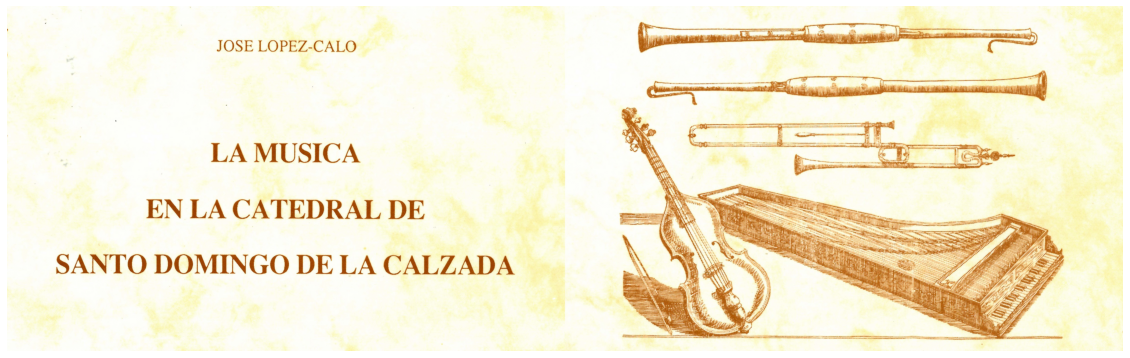

In [3]:
img = cv2.imread('banner.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.imshow(img)
plt.show()

# Aplicación Web para realizar búsquedas de las obras y las frases que aparecen en el libro

In [10]:
def remove_punctuation(frase):
  char = re.sub('[%s]' % re.escape(string.punctuation.replace('-','')),'',frase)
  char = char.replace('¿','').replace('?','').replace('`','').replace('´','').replace('#','').lower()
  char = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", char), 0, re.I
    )
  char = normalize( 'NFC', char)
  return char

def verPagina(num_obra):
  for cla in ini_Obras:
    if num_obra in ini_Obras[cla]: return cla


def beep(audio_path):
  display(Audio(audio_path, autoplay=False))

def buscar_texto(frase,texto): # Las fotos están en una carpeta. El texto es nuestro diccionario con la información.
  frase2 = frase.upper()
  fotos = []
  frase = frase.split()
  n = len(frase)
  frase = ''.join(frase)
  frase =  remove_punctuation(frase).replace(' ','')
  for cla in texto:
    foto = cv2.imread('Fotos/pag' + str(cla) + '.jpg') # Vamos abriendo las fotos página a página
    foto = cv2.cvtColor(foto, cv2.COLOR_BGR2RGB)
    N = len(texto[cla]['text'])
    j = 0
    encontrado = False
    while j < N:
      k = j
      b = True
      siguiente = texto[cla]['text'][j:n+j]
      if siguiente[-1][-1] == '-':
        siguiente = ''.join(texto[cla]['text'][j:n+j+1])
        siguiente = siguiente.replace(' ','').replace('-','')
        j = j + 1
      else:
        siguiente = ''.join(siguiente)
        j = j + 1
        b = False

      if frase in siguiente:
        encontrado = True
        x = texto[cla]['left'][k]
        y = texto[cla]['top'][k]
        h = texto[cla]['height'][k]
        w = 0
        for i in range(k,k+n):
          w = w + texto[cla]['width'][i] + 7 # le añado un poco más para tener en cuenta la separación entre palabras 
        cv2.rectangle(foto,(x-10,y-10),(x+w+10,y+h+10),(226,182,19),2)
        if b:
          x = texto[cla]['left'][k+n]
          y = texto[cla]['top'][k+n]
          h = texto[cla]['height'][k+n]
          w = texto[cla]['width'][k+n]
          cv2.rectangle(foto,(x-10,y-10),(x+w+10,y+h+10),(226,182,19),2)
    if encontrado == True: fotos.append(foto)

  n = len(fotos)
  if n == 0:
    print('La palabra no aparece o está mal escrita.')
  else:
    if len(fotos) == 1:
      print('LA PALABRA "' + frase2 + '" APARECE EN ' + str(1) + ' PÁGINA.')
    else:
      print('LA PALABRA "' + frase2 + '" APARECE EN ' + str(len(fotos)) + ' PÁGINA.')
    fig, ax = plt.subplots(n,1,figsize=(16*n,16*n))
    for i in range(0,n):
      if n == 1:
        ax.imshow(fotos[i])
      else:
        ax[i].imshow(fotos[i])
    plt.show()

def buscar(autor,TO):
  if autor == 'Todos' and TO == 'Todas':
    Foto = np.zeros((100,1000,3),dtype='uint8') + 255
    cv2.putText(Foto, 'Obras del libro', (100, 60), cv2.FONT_HERSHEY_TRIPLEX,0.8, (0, 0, 0), 2)
    fig, ax = plt.subplots(1,1,figsize=(16,16))
    ax.axis('off')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.imshow(Foto,cmap=plt.cm.binary)
    plt.show()
    for autor in Obras_final:
      for i in Obras_final[autor]:
        Foto = []
        pag = verPagina(i)
        n = len(Obras_final[autor][i]['Coordenadas'])
        for j in range(0,n):
          x,y,w,h = Obras_final[autor][i]['Coordenadas'][j]
          fot = cv2.imread('Fotos/pag'+str(pag+j)+'.jpg')
          fot = cv2.cvtColor(fot,cv2.COLOR_BGR2RGB)
          Foto.append(fot[y:y+h+5,x:x+w])
        Foto = np.concatenate([np.zeros((100,1080,3),dtype='uint8')+255]+Foto,axis=0)
        types = 'Tipos: ' + ', '.join([remove_punctuation(t) for t in Obras_final[autor][i]['Tipo']])
        cv2.rectangle(Foto, (0,0), (1080,50), (119, 90, 17), 2)
        cv2.putText(Foto, types, (150, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
        cv2.putText(Foto, 'Pagina: ' + str(pag), (500, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
        beep('audio/obra'+str(i)+'.wav')
        fig, ax = plt.subplots(1,1,figsize=(16,16))
        ax.imshow(Foto,cmap=plt.cm.binary)
        ax.axis('off')
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        plt.show()
        print('')
  elif autor == 'Todos' and TO != 'Todas':
    Foto = np.zeros((100,1000,3),dtype='uint8') + 255
    cv2.putText(Foto, 'Obras de tipo ' + remove_punctuation(TO), (100, 60), cv2.FONT_HERSHEY_TRIPLEX,0.8, (0, 0, 0), 2)
    fig, ax = plt.subplots(1,1,figsize=(16,16))
    ax.axis('off')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.imshow(Foto,cmap=plt.cm.binary)
    plt.show()
    for i in Obras_final_TO[TO]:
      Foto = []
      pag = verPagina(i)
      n = len(Obras_final_TO[TO][i]['Coordenadas'])
      for j in range(0,n):
        x,y,w,h = Obras_final_TO[TO][i]['Coordenadas'][j]
        fot = cv2.imread('Fotos/pag'+str(pag+j)+'.jpg')
        fot = cv2.cvtColor(fot,cv2.COLOR_BGR2RGB)
        Foto.append(fot[y:y+h+5,x:x+w])
      Foto = np.concatenate([np.zeros((100,1080,3),dtype='uint8')+255]+Foto,axis=0)
      Aut = 'Autor: ' + Obras_final_TO[TO][i]['Autor']
      cv2.rectangle(Foto, (0,0), (1080,50), (119, 90, 17), 2)
      cv2.putText(Foto, Aut, (50, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
      cv2.putText(Foto, 'Pagina: ' + str(pag), (350, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
      cv2.putText(Foto, 'Obra: ' + str(i), (650, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
      beep('audio/obra'+str(i)+'.wav')
      fig, ax = plt.subplots(1,1,figsize=(16,16))
      ax.imshow(Foto,cmap=plt.cm.binary)
      ax.axis('off')
      ax.xaxis.set_ticklabels([])
      ax.yaxis.set_ticklabels([])
      plt.show()
      print('')
  elif autor != 'Todos' and TO == 'Todas':
    if autor in Autores2:
      autor = Autores[Autores2.index(autor)]
    elif autor in Autores22:
      autor = Autores[Autores22.index(autor)]
    Foto = np.zeros((100,1000,3),dtype='uint8') + 255
    cv2.putText(Foto, 'Obras del autor/a ' + remove_punctuation(autor), (100, 60), cv2.FONT_HERSHEY_TRIPLEX,0.8, (0, 0, 0), 2)
    fig, ax = plt.subplots(1,1,figsize=(16,16))
    ax.axis('off')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.imshow(Foto,cmap=plt.cm.binary)
    plt.show()
    for i in Obras_final[autor]:
      Foto = []
      pag = verPagina(i)
      n = len(Obras_final[autor][i]['Coordenadas'])
      for j in range(0,n):
        x,y,w,h = Obras_final[autor][i]['Coordenadas'][j]
        fot = cv2.imread('Fotos/pag'+str(pag+j)+'.jpg')
        fot = cv2.cvtColor(fot,cv2.COLOR_BGR2RGB)
        Foto.append(fot[y:y+h+5,x:x+w])
      Foto = np.concatenate([np.zeros((100,1080,3),dtype='uint8')+255]+Foto,axis=0)
      types = 'Tipo: ' + ', '.join([remove_punctuation(t) for t in Obras_final[autor][i]['Tipo']])
      cv2.rectangle(Foto, (0,0), (1080,50), (119, 90, 17), 2)
      cv2.putText(Foto, types, (50, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
      cv2.putText(Foto, 'Pagina: ' + str(pag), (350, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
      cv2.putText(Foto, 'Obra: ' + str(i), (650, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
      beep('audio/obra'+str(i)+'.wav')
      fig, ax = plt.subplots(1,1,figsize=(16,16))
      ax.imshow(Foto,cmap=plt.cm.binary)
      ax.axis('off')
      ax.xaxis.set_ticklabels([])
      ax.yaxis.set_ticklabels([])
      plt.show()
      print('')
  else:
    if autor in Autores2:
      autor = Autores[Autores2.index(autor)]
    elif autor in Autores22:
      autor = Autores[Autores22.index(autor)]
    Foto = np.zeros((100,1000,3),dtype='uint8') + 255
    cv2.putText(Foto, 'Obras del autor/a ' + remove_punctuation(autor) + ' con tipo ' + remove_punctuation(TO), (100, 60), cv2.FONT_HERSHEY_TRIPLEX,0.7, (0, 0, 0), 2)
    fig, ax = plt.subplots(1,1,figsize=(16,16))
    ax.axis('off')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.imshow(Foto,cmap=plt.cm.binary)
    plt.show()
    for i in Obras_final[autor]:
      Foto = []
      pag = verPagina(i)
      n = len(Obras_final[autor][i]['Coordenadas'])
      for j in range(0,n):
        x,y,w,h = Obras_final[autor][i]['Coordenadas'][j]
        fot = cv2.imread('Fotos/pag'+str(pag+j)+'.jpg')
        fot = cv2.cvtColor(fot,cv2.COLOR_BGR2RGB)
        Foto.append(fot[y:y+h+5,x:x+w])
      Foto = np.concatenate([np.zeros((100,1080,3),dtype='uint8')+255]+Foto,axis=0)
      types = 'Tipo: ' + ', '.join([remove_punctuation(t) for t in Obras_final[autor][i]['Tipo']])
      if TO in Obras_final[autor][i]['Tipo']:
        cv2.rectangle(Foto, (0,0), (1080,50), (119, 90, 17), 2)
        cv2.putText(Foto, 'Pagina: ' + str(pag), (50, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
        cv2.putText(Foto, 'Obra: ' + str(i), (450, 30), cv2.FONT_HERSHEY_TRIPLEX,0.65, (0, 0, 0), 1)
        beep('audio/obra'+str(i)+'.wav')
        fig, ax = plt.subplots(1,1,figsize=(16,16))
        ax.imshow(Foto,cmap=plt.cm.binary)
        ax.axis('off')
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        plt.show()
        print('')

In [11]:
with open("Obras_final.pickle", "rb") as f:
    Obras_final = pickle.load(f)
with open("Obras_final_TO.pickle", "rb") as f:
    Obras_final_TO = pickle.load(f)
with open("ini_Obras.pickle", "rb") as f:
    ini_Obras = pickle.load(f)
with open("texto.pickle", "rb") as f:
    texto = pickle.load(f)

Autores = list(Obras_final.keys())
Autores.remove('')
Autores2 = [remove_punctuation(a) for a in Autores]
Autores22 = []
for a in Autores:
  if len(a.split(sep=',')) > 1:
    Autores22.append(remove_punctuation(' '.join(a.split(sep=',')[::-1]))[1:])
  else:
    Autores22.append(remove_punctuation(' '.join(a.split(sep=',')[::-1])))

In [13]:
keyword=widgets.Dropdown(
    options=['Todos']+Autores,
    description='Autor:',
    disabled=False,
)
keyword_Obs=widgets.Dropdown(
    options=['Todas']+list(Obras_final_TO.keys()),
    description='Tipo de Obra:',
    disabled=False,
)
display(keyword,keyword_Obs)


button = widgets.Button(description="Buscar")
display(button)

output = widgets.Output()
@output.capture()
def on_button_clicked(b):
  output.clear_output()
  output2.clear_output()
  buscar(keyword.value,keyword_Obs.value)

print()

keyword2=widgets.Text(
    placeholder='Búsqueda clásica (Tarda mucho)',
    disabled=False
)
display(keyword2)


button2 = widgets.Button(description="Buscar")
display(button2)

output2 = widgets.Output()
@output2.capture()
def on_button_clicked2(b):
  output2.clear_output()
  output.clear_output()
  if keyword2.value == '': 
    print('No has escrito nada.')
  else:
    buscar_texto(keyword2.value,texto)


button.on_click(on_button_clicked)
button2.on_click(on_button_clicked2)
display(output)
display(output2)

Dropdown(description='Autor:', options=('Todos', 'Abadía, Antonio', 'Abella, Pablo', 'Aguayo, Cándido', 'Aguil…

Dropdown(description='Tipo de Obra:', options=('Todas', 'Himno', 'Lamentación', 'Magnificat', 'Misa', 'Motete'…

Button(description='Buscar', style=ButtonStyle())

Text(value='', placeholder='Búsqueda clásica (Tarda mucho)')

Button(description='Buscar', style=ButtonStyle())

Output()

Output()